In [1]:
import sys
import numpy as np
from time import time
from pynq import Overlay
from pynq import allocate
from scipy.linalg import dft
import matplotlib.pyplot as plt

### 生成频率为100Hz的正弦测试信号，并显示测试信号图像

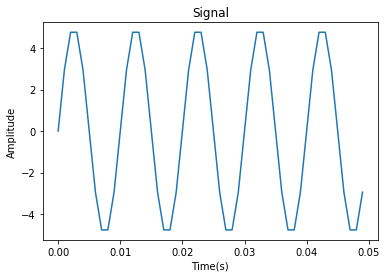

In [3]:
Fs = 1000 #采样频率
T = 1/Fs #采样周期
SIZE = 1024 #信号长度
t = np.arange(SIZE)*T

a = 5 * np.sin(2*np.pi*100*t)
golden_op=np.fft.fft(a)
plt.plot(t[:50], a[:50])
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Signal")
plt.show()

### 初始化一些数组并加载DFT硬件设计

In [4]:
ol=Overlay('DFT.bit')
real_error=np.zeros(SIZE)
imag_error=np.zeros(SIZE)
ind=np.arange(SIZE)
real_rmse=np.zeros(SIZE)
imag_rmse=np.zeros(SIZE)

### 对HLS编写的DFT算法进行测试，并输出计算时间

In [5]:
#内存分配
in_real = allocate(shape=(SIZE,), dtype=np.float32) 
in_img = allocate(shape=(SIZE,), dtype=np.float32)           
out_real = allocate(shape=(SIZE,), dtype=np.float32) 
out_img = allocate(shape=(SIZE,), dtype=np.float32)
np.copyto(in_real, a.real)
np.copyto(in_img, a.imag)

DFT = ol.dft_0
start_time = time()

DFT.write(0x28, out_real.device_address)
DFT.write(0x34, out_img.device_address)
DFT.write(0x10, in_real.device_address)
DFT.write(0x1c, in_img.device_address)
DFT.write(0x00, 0x01)

while (DFT.read(0x00) & 0x4) == 0x0:
    continue
end_time = time()
print("耗时：: " + str(end_time - start_time) + " s")
print(out_real)
print(out_img)

耗时：: 0.037966251373291016 s
[12.4494915 12.450814  12.45505   ... 12.461853  12.45505   12.450814 ]
[ 0.         -0.04720106 -0.09444172 ...  0.1417504   0.09444172
  0.04720106]


### 计算DFT模块与FFT的RMSE误差，显示误差并且判断是否通过

In [6]:
#计算RMSE误差
for i in range(SIZE):
    real_error[i]="{}".format(abs(out_real[i]-golden_op.real[i]))
    imag_error[i]="{}".format(abs(out_img[i]-golden_op.imag[i]))
sum_sq_real=0
sum_sq_imag=0
for i in range(SIZE):
    sum_sq_real +=(real_error[i]*real_error[i])
    real_rmse = np.sqrt(sum_sq_real / (i+1))
    sum_sq_imag +=(imag_error[i]*imag_error[i])
    imag_rmse = np.sqrt(sum_sq_imag / (i+1))
print("Real RMSE: ", real_rmse, "Imag RMSE:", imag_rmse)    
if real_rmse < 0.001 and imag_rmse < 0.001:
    print("PASS")
else:
    print("FAIL")

Real RMSE:  6.219659024136314e-05 Imag RMSE: 2.2669007258484035e-05
PASS


### 可视化FFT与DFT的RMSE误差

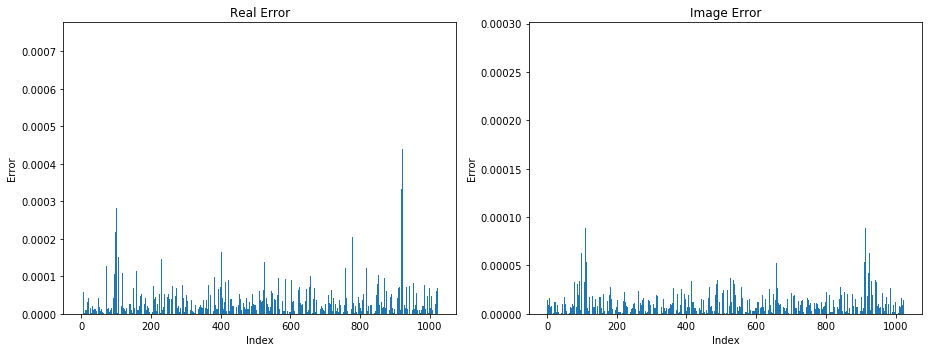

In [7]:
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.bar(ind,real_error)
plt.title("Real Error")
plt.xlabel("Index")
plt.ylabel("Error")
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,imag_error)
plt.title("Image Error")
plt.xlabel("Index")
plt.ylabel("Error")
plt.tight_layout()

### 对经过DFT以及FFT后的信号取绝对值，并且取单侧频谱

In [8]:
f = np.arange(int(SIZE/2))*Fs/SIZE;

#DFT处理结果
HLS_DFT=np.array(out_real + out_img* 1j,dtype=complex)
HLS_DFT_abs = np.abs(HLS_DFT)[:int(SIZE/2)]   # 单侧频谱

#FFT处理结果
PY_FFT = golden_op
PY_FFT_abs = np.abs(PY_FFT)[:int(SIZE/2)]    # 单侧频谱

### 绘制DFT与FFT的频谱图，可以发现主频为100Hz，与测试信号频率相同

No handles with labels found to put in legend.
No handles with labels found to put in legend.


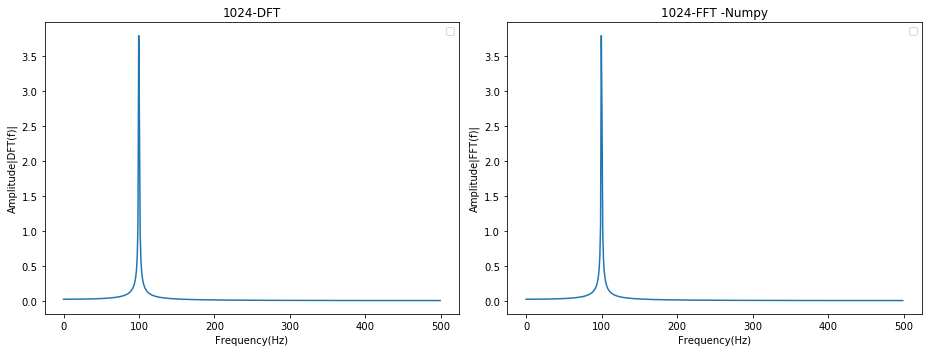

In [9]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(f,2*HLS_DFT_abs/SIZE) 
plt.title("1024-DFT")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude|DFT(f)|")
plt.legend()
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(f,2*PY_FFT_abs/SIZE) 
plt.title("1024-FFT -Numpy")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude|FFT(f)|")
plt.legend()
plt.tight_layout()
plt.show()